In [12]:
import random
import tensorflow as tf
import numpy as np
from typing import List, Tuple
from skimage.draw import disk, rectangle, rectangle_perimeter
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, ZeroPadding2D
from tensorflow.keras.optimizers import Adam

In [13]:
def gen(stop = 1):
  image_size = (224, 224)                                                         # высота, ширина
  i = 0
  while i < stop:
   
    im = np.ones((image_size[0],image_size[1], 3))                                # генерируем фон белого цвета
    im[:,:,0], im[:,:,1], im[:,:,2] = np.random.rand(3)                           # меняем цвет на рандомный

    figure_type = random.choice(['disk', 'rectangle'])                            # выбираем тип фигуры, цвет
    
    coords_centr = [random.uniform(0, 1), random.uniform(0, 1)]                   # Выбираем позицию центра 0-1-верх/низ, 0-1 - лево/право
  
    if figure_type == 'disk':                                                     # если фигура круг     
      radius = random.uniform(0.05, 0.10)                                         # задаём радиус
      
      bounding_top = max(coords_centr[0] - radius, 0)                             # задаём ограничения c 4х сторон
      bounding_left = max(coords_centr[1] - radius, 0)
      bounding_bottom = min(coords_centr[0] + radius, 1)
      bounding_right = min(coords_centr[1] + radius, 1)

      rr, cc = disk((coords_centr[0] * image_size[0], coords_centr[1] * image_size[1]), radius * min(image_size), shape=image_size)       # получаем координаты пикселей круга

      figure_type = 0.0                                                           # тип фигуры 0

   
    if figure_type == 'rectangle':                                                # если фигура прямоугольника
      rectangle_size  = [random.uniform(0.05, 0.20), random.uniform(0.05, 0.20)]  # [высота, ширина]
      bounding_top    = max(coords_centr[0] - rectangle_size[0] / 2, 0)           # задаём ограничения c 4х сторон
      bounding_left   = max(coords_centr[1] - rectangle_size[1] / 2, 0)
      bounding_bottom = min(coords_centr[0] + rectangle_size[0] / 2, 1)
      bounding_right  = min(coords_centr[1] + rectangle_size[1] / 2, 1)

      start = [round(bounding_top * image_size[0]), round(bounding_left * image_size[1])]                                           # промежуточная переменная, координаты верхнего левого угла прямоугольника
      extent = [round((bounding_bottom - bounding_top) * image_size[0]), round((bounding_right - bounding_left) * image_size[1])]   # промежуточная переменная, размер прямоугольника

      rr, cc = rectangle(start , extent=extent, shape=image_size)                                                                   # # получаем координаты пикселей прямоугольника

      figure_type = 1.0                                                                                                             # тип фигуры 1

    im[rr,cc,0], im[rr,cc,1], im[rr,cc,2] = np.random.rand(3)                         # отрисовываем фигуру рандгомным цветом


    # Выделяем рамкой объект 
    start = (bounding_top * image_size[0], bounding_left * image_size[1])             # промежуточная переменная, координаты верхнего левого угла рамки
    end =   (bounding_bottom * image_size[0], bounding_right * image_size[1])             # промежуточная переменная, размер прямоугольника
    rr, cc = rectangle_perimeter(start, end=end, shape=image_size)                    # получаем координаты пикселей рамки

    im[rr,cc,0], im[rr,cc,1], im[rr,cc,2] = (0, 0, 0)                                 # отрисовываем рамку

  
    yield im, np.array([figure_type,  bounding_top, bounding_left, bounding_bottom, bounding_right])

    i += 1


dataset = tf.data.Dataset.from_generator(                                           # формируем датасет генератор 
     gen,
     args = [1],
     output_signature=(
         tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float64, name=None),
         tf.TensorSpec(shape=(5), dtype=tf.float64, name=None))                     
)

dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)                            # может так будет быстрее работать

tf.Tensor([0.         0.68435947 0.10727554 0.83268142 0.25559749], shape=(5,), dtype=float64)


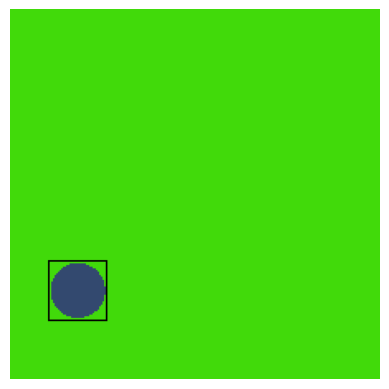

In [14]:
for ds in dataset.repeat().take(1):
  print(ds[1])
  plt.axis('off')
  plt.imshow(ds[0])

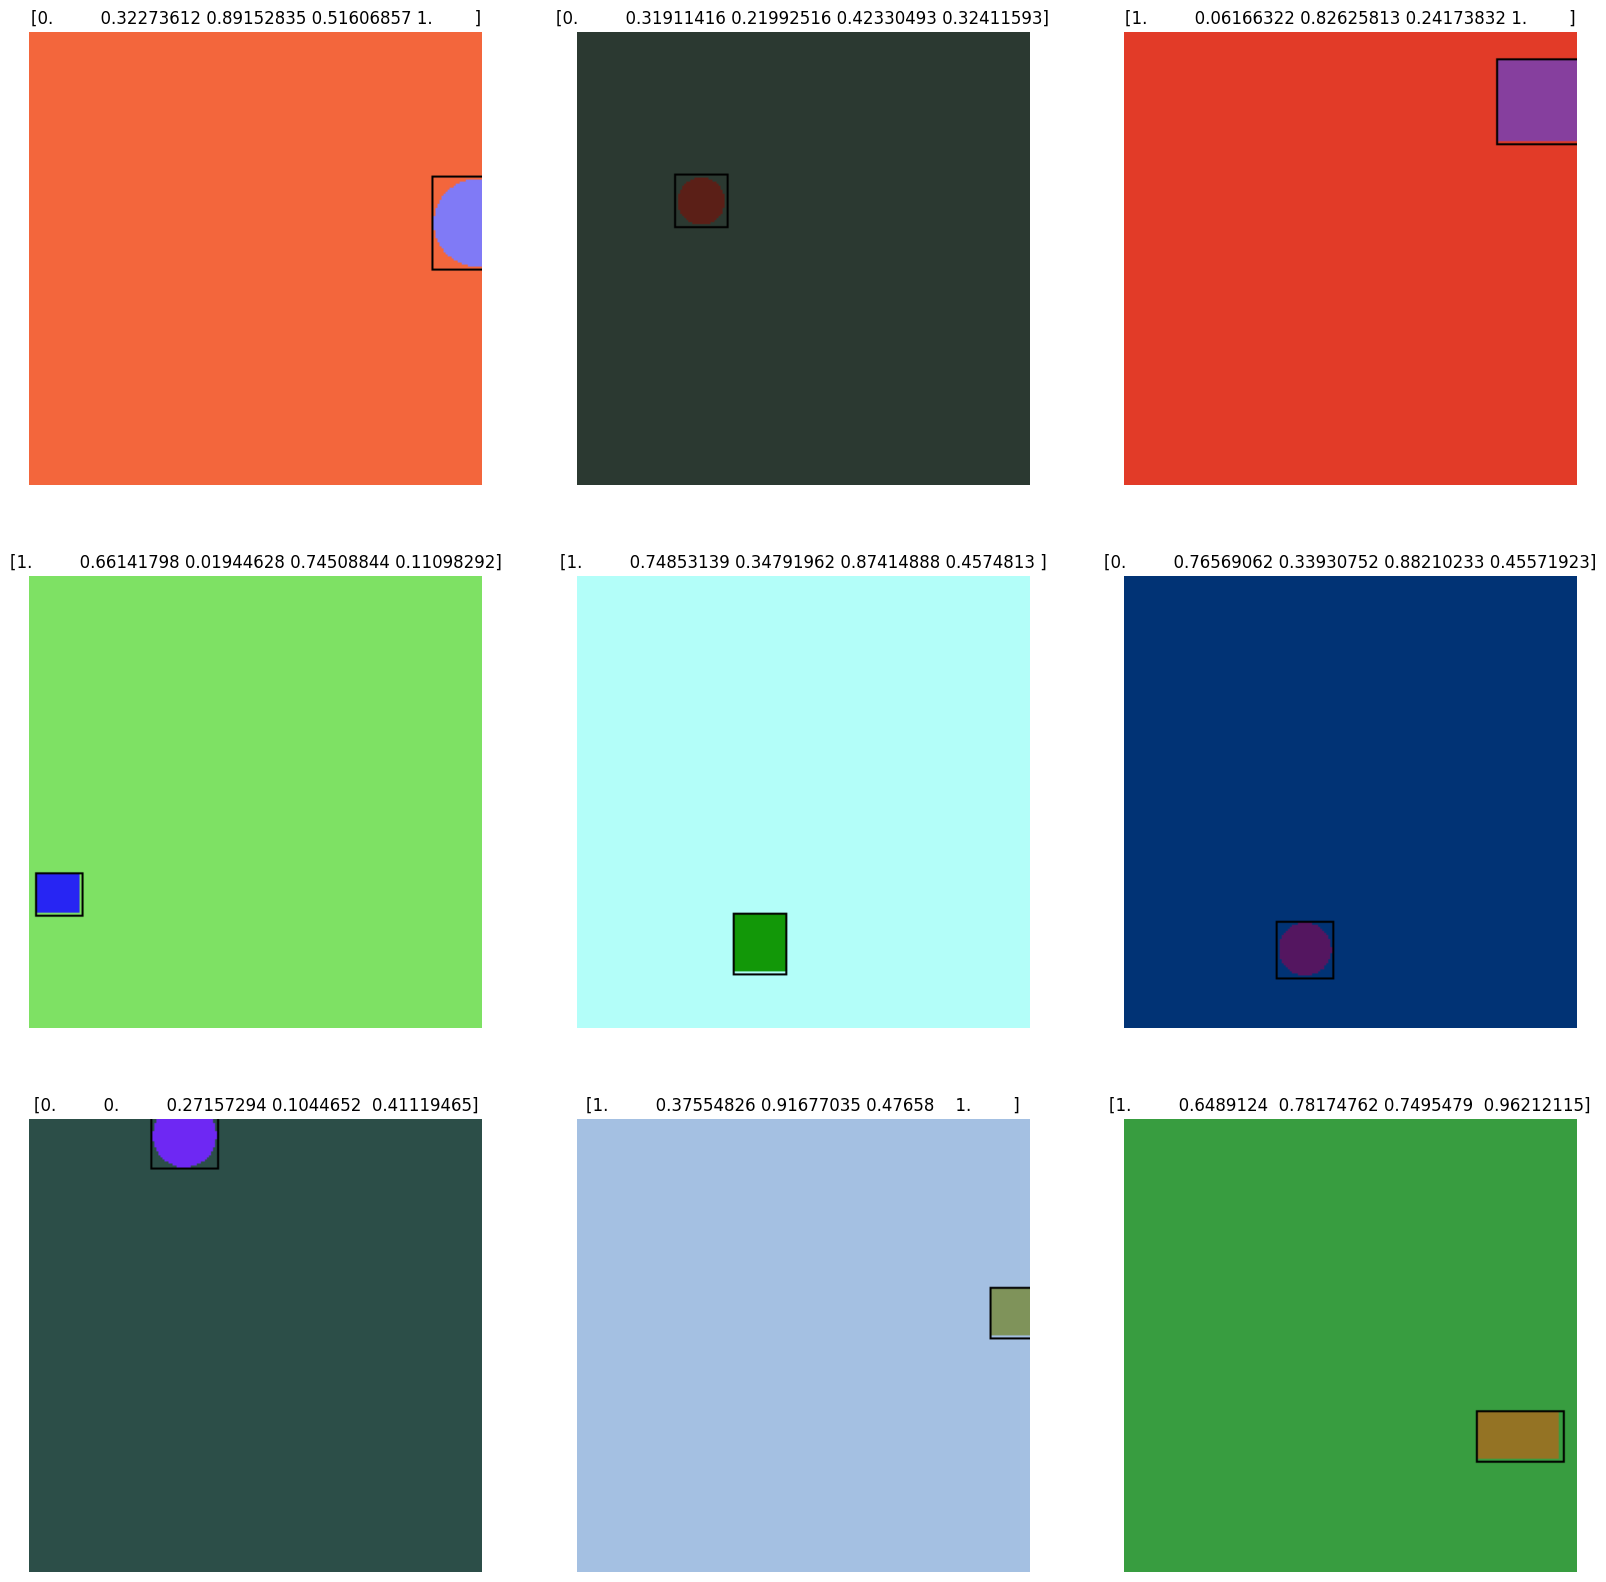

In [15]:
line = 3
column = 3

fig, axs = plt.subplots(line, column, figsize = (20, 20))

im = []
lable = []

for ds in dataset.repeat().take(line * column):
  im.append(ds[0])
  lable.append(ds[1])

im = np.array(im)
lable = np.array(lable)

i = 0

for l in range(line):
  for c in range(column):

    title = str(lable[i])
    axs[l][c].axis('off')
    axs[l][c].imshow(im[i])
    axs[l][c].set_title(title)

    i += 1

In [20]:
import tfr.keras.metrics.MeanAveragePrecisionMetric
inputs = keras.Input(shape=(224, 224, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])                              # сложение слоёв или прокидывание результата одного слоя минуя другие.

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
 #            metrics=[tfr.keras.metrics.MeanAveragePrecisionMetric()])

ModuleNotFoundError: ignored

In [7]:
model.fit(dataset.repeat().batch(2).take(10), epochs=1, verbose=1)

10/10 [==============================] - 10s 874ms/step - loss: 41.2231 - accuracy: 0.2500
